In [3]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input

C:\Users\gupta\anaconda3\lib\site-packages\ale_py\roms\__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


## Pong

Deep Q learning with memory buffer - varying probs to oversample minority (cases when you win), action every 4 frame, and linear annealing

In [4]:
# function to convert each image into lesser size
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array 
    I = I[35:195,:,:].copy() # crop the top of the image...score image doesn't matter for how to play
    I = I[::2,::2,0].copy()
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.array(I.copy())

C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def create_model(height,width,channels):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Conv2D(32,(8,8),strides=4,activation='relu')(imp)
    mid = Conv2D(64,(4,4),strides=2,activation='relu')(mid)
    mid = Conv2D(64,(3,3),strides=1,activation='relu')(mid)
    mid = Flatten()(mid)
    mid = Dense(256,activation='relu')(mid)
    out0 = Dense(1,activation='linear',name='out0')(mid)
    out1 = Dense(1,activation='linear',name='out1')(mid)
    out2 = Dense(1,activation='linear',name='out2')(mid)
    model = Model(imp,[out0,out1,out2]) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=25e-6),loss=tf.keras.losses.Huber())
    
    return model

In [6]:
frames_to_net = 4              # how many previous frames will we feed the NN
possible_actions = [0,2,3]
mod = create_model(80,80,frames_to_net)
mod.call = tf.function(mod.call,experimental_relax_shapes=True)

mod.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 19, 19, 32)   8224        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     32832       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 6, 6, 64)     36928       ['conv2d_1[0][0]']               
                                                                                              

In [5]:
def play1game(model,ep):
    env0 = gym.make("Pong-v0")
    pix = env0.reset()
    pix = prepro(pix)
    frames_this_game = 0
    feed = np.zeros((1,80,80,frames_to_net))
    feed[0,:,:,0] = pix.copy() # 0 is the most recent frame t; 1 the previous one t+1 and so one
    
    frame_array = []
    action_array = []
    reward_array = []
    
    score = 0
    done = False
    while not done:
        # updating action every 4 frames
        # but taking that action for the 4 frames just not using the prediction for action
        if frames_this_game % 4 == 0:
            if np.random.random() < ep:
                action = np.random.choice(3)
            else:
                vf = mod(feed,training=False)
                vf = [vf[0][0,0].numpy(),vf[1][0,0].numpy(),vf[2][0,0].numpy()]
                action = np.argmax(vf)
        action0 = possible_actions[action]
        pix_new, reward, done, info = env0.step(action0)
        frame_array.append(pix)
        action_array.append(action)
        reward_array.append(reward)
        pix = prepro(pix_new)
        frames_this_game += 1

        for f in range(1,frames_to_net):
            feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
        feed[0,:,:,0] = pix.copy()
        score += reward
    return frame_array, action_array, reward_array, score

In [7]:
# testing the likelihood of taking each action without any training
frames, actions, rewards, score = play1game(mod,0.5)
print(np.mean(np.array(actions)==0),np.mean(np.array(actions)==1),np.mean(np.array(actions)==2))


0.25194401244167963 0.26127527216174184 0.4867807153965785


In [53]:
# discounting factor
delt = 0.99

# setting up variable for memory buffer
# ngames = 1000
ngames = 100
nbatch = 10
buffn = 200000
warmupgames = 50
len_buff = 0
buffer = {'frames':[],'actions':[], 'rewards':[]}

# eps vector for each gradient for linear annealing
epsvec = np.linspace(1,0.05,ngames)

In [56]:
output_qdl = {'game':[-1]*ngames, 'score':[-100]*ngames, 'time':[-1]*ngames}

overall_start = time.time()

for game in range(ngames):
    start = time.time()
    frames, actions, rewards, score = play1game(mod,epsvec[game])
    buffer['frames'] += frames.copy()
    buffer['actions'] += actions.copy()
    buffer['rewards'] += rewards.copy()
    len_buff += len(actions)
    if len_buff > buffn:
        excess = len_buff - buffn
        buffer['frames'] = buffer['frames'][excess:].copy()
        buffer['actions'] = buffer['actions'][excess:].copy()
        buffer['rewards'] = buffer['rewards'][excess:].copy()
        len_buff = len(buffer['actions'])
    
    # rewards = np.array(rewards)
    # actions = np.array(actions)
    
    nframes = len(frames)
    current_frames = np.zeros((nframes,80,80,frames_to_net))
    future_frames = np.zeros((nframes,80,80,frames_to_net))
  
    if game >= warmupgames:
        # choosing the frames from memory buffer based on the reward
        # weighing the frames 
        # something like over/under sampling in unbalanced class
        prob = np.ones(len_buff)
        prob[np.array(buffer['rewards']) > 0] = 5.0
        prob /= np.sum(prob)
        which_choose = np.random.choice(len_buff,size=nframes,replace=False,p=prob)
    
        rewards = np.zeros(nframes)
        actions = np.zeros(nframes)
        for i in range(len(which_choose)):
            grab = which_choose[i]
            rewards[i] = buffer['rewards'][grab]
            actions[i] = buffer['actions'][grab]
            # creating frame - current t (for prediction) and t+1 (for truth)
            for f in range(frames_to_net):
                if grab-f > 0:
                    current_frames[i,:,:,f] = buffer['frames'][grab-f].copy()
                if (grab-f+1 > 0) & (grab-f+1 < len_buff-1):
                    future_frames[i,:,:,f] = buffer['frames'][grab-f+1].copy()


    target_vf = mod.predict(future_frames)

    # vectors of truth
    y0 = np.zeros((nframes,1))
    y1 = np.zeros((nframes,1))
    y2 = np.zeros((nframes,1))
    
    # weight for training neural network based on the "truth"
    weight0 = np.zeros(nframes)
    weight1 = np.zeros(nframes)
    weight2 = np.zeros(nframes)
  

    for grab in range(nframes):
        rhs = rewards[grab]
        # terminal condition will be when we win a game
        # 
        if rhs == 0:
            rhs = delt*np.max([target_vf[0][grab],target_vf[1][grab],target_vf[2][grab]])
        if actions[grab] == 0:
            y0[grab,0] = rhs
            weight0[grab] = 1
        elif actions[grab] == 1:
            y1[grab,0] = rhs
            weight1[grab] = 1
        else:
            y2[grab,0] = rhs
            weight2[grab] = 1
  
    mod.fit(current_frames,[y0,y1,y2],epochs=1,batch_size=nbatch,verbose=0,sample_weight={'out0':weight0,'out1':weight1,'out2':weight2},use_multiprocessing=True)
    stop = time.time()
    # print([game, score, epsvec[game], stop-start])
    
    output_qdl['game'][game] = game
    output_qdl['score'][game] = score
    output_qdl['time'][game] = time
    
    if game % 10 == 0:
        print('Game number ', game, [score, epsvec[game], stop-start])

overall_end = time.time()
print('total run time, ', (overall_end - overall_start)/60, 'minutes')

Game number  0 [-21.0, 1.0, 3.597517251968384]
Game number  10 [-21.0, 0.9040404040404041, 4.0382843017578125]
Game number  20 [-20.0, 0.8080808080808081, 5.42009973526001]
Game number  30 [-21.0, 0.7121212121212122, 4.9214231967926025]
Game number  40 [-21.0, 0.6161616161616161, 5.239348649978638]
Game number  50 [-21.0, 0.5202020202020202, 5.495059967041016]
Game number  60 [-21.0, 0.4242424242424243, 5.062440633773804]
Game number  70 [-21.0, 0.3282828282828283, 5.357397556304932]
Game number  80 [-20.0, 0.23232323232323238, 6.475332498550415]
Game number  90 [-21.0, 0.13636363636363646, 6.127270698547363]
total run time,  9.284054215749105 minutes


In [58]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
mod.save('saved_model/dql')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/dql\assets


C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([75.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  5.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

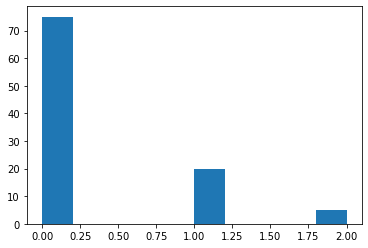

In [62]:
import matplotlib.pyplot as plt
plt.hist([x+21 for x in output_qdl['score']])